# Bagging (Bootstrap Aggregation) for Steering Classification

This notebook trains and evaluates Bagged Decision Trees on the steering image dataset.

**Key Concepts:**
- Bootstrap: Sample with replacement from original data
- Aggregation: Average predictions from multiple models
- Reduces variance of high-variance learners (like decision trees)
- Most effective when base learners are unstable


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

from utils import (
    load_data, preprocess_data, evaluate_model, 
    save_results, print_class_distribution, CLASSES, RANDOM_STATE
)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Preprocess Data


In [2]:
# Load data
data = load_data()

X_raw, y_raw = data['raw']
X_eng, y_eng, feature_names = data['engineered']

print("Preprocessing RAW data with PCA:")
raw_processed = preprocess_data(
    X_raw, y_raw, 
    test_size=0.2, 
    apply_pca_reduction=True, 
    pca_variance=0.95,
    scale=False
)

print("\nPreprocessing ENGINEERED data:")
eng_processed = preprocess_data(
    X_eng, y_eng, 
    test_size=0.2, 
    apply_pca_reduction=False,
    scale=False
)

print("\nTraining set class distribution:")
print_class_distribution(raw_processed['y_train'], raw_processed['label_encoder'])


Loaded 9900 raw images
  Shape: (9900, 4096)
  Class distribution: {np.str_('forward'): np.int64(7343), np.str_('left'): np.int64(1620), np.str_('right'): np.int64(937)}
Loaded 9900 samples with 38 engineered features
  Class distribution: {'forward': np.int64(7343), 'left': np.int64(1620), 'right': np.int64(937)}
Preprocessing RAW data with PCA:
Train/Test split: 7920/1980 samples
PCA: 4096 features -> 40 components
  Variance retained: 95.02%

Preprocessing ENGINEERED data:
Train/Test split: 7920/1980 samples

Training set class distribution:
Class Distribution:
  forward: 5874 (74.2%)
  left: 1296 (16.4%)
  right: 750 (9.5%)


## 2. Train Bagging Classifiers


Training Bagging Classifier on RAW (PCA) features...
OOB Score: 0.9186

Model: Bagging (Decision Trees) | Features: raw
Accuracy:          0.9172
Balanced Accuracy: 0.8513
Macro F1:          0.8703
Weighted F1:       0.9155
Macro Precision:   0.8932
Macro Recall:      0.8513
ROC-AUC (macro):   0.9758

Per-class metrics:
  forward   : F1=0.9452, Precision=0.9284, Recall=0.9626
  left      : F1=0.8233, Precision=0.8949, Recall=0.7623
  right     : F1=0.8424, Precision=0.8564, Recall=0.8289

Classification Report:
              precision    recall  f1-score   support

     forward       0.93      0.96      0.95      1469
        left       0.89      0.76      0.82       324
       right       0.86      0.83      0.84       187

    accuracy                           0.92      1980
   macro avg       0.89      0.85      0.87      1980
weighted avg       0.92      0.92      0.92      1980



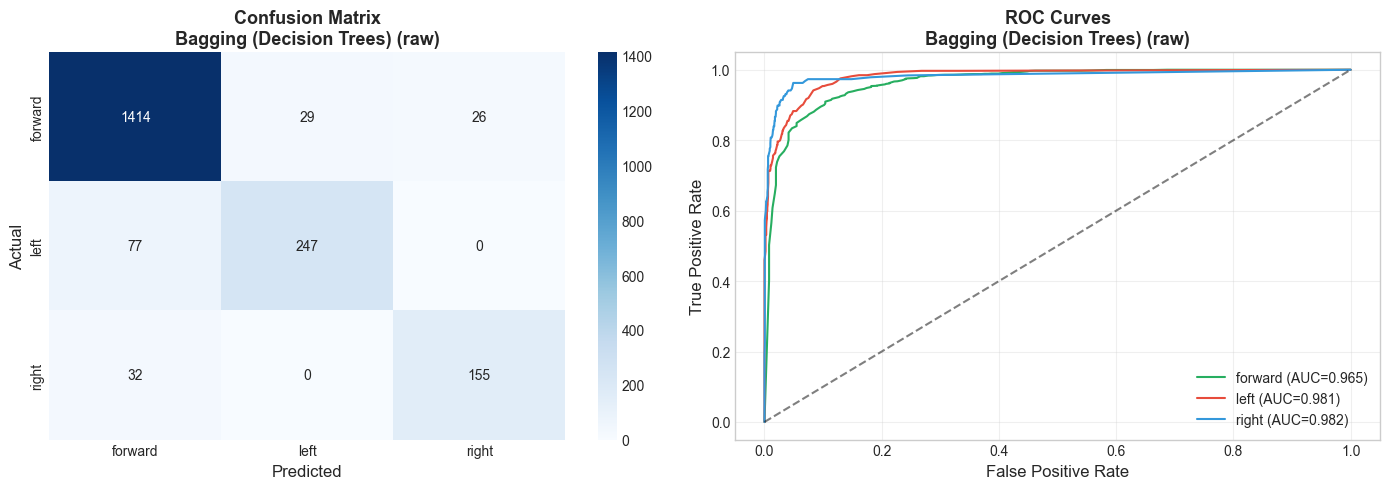

In [3]:
# Train Bagging on RAW (PCA) features
print("Training Bagging Classifier on RAW (PCA) features...")

base_estimator = DecisionTreeClassifier(
    max_depth=None,  # Fully grown trees
    class_weight='balanced',
    random_state=RANDOM_STATE
)

bagging_raw = BaggingClassifier(
    estimator=base_estimator,
    n_estimators=100,
    max_samples=1.0,  # Bootstrap sample size
    max_features=1.0,  # Use all features (unlike Random Forest)
    bootstrap=True,
    oob_score=True,  # Out-of-bag score
    random_state=RANDOM_STATE,
    n_jobs=-1
)

bagging_raw.fit(raw_processed['X_train'], raw_processed['y_train'])

print(f"OOB Score: {bagging_raw.oob_score_:.4f}")

results_bag_raw = evaluate_model(
    bagging_raw,
    raw_processed['X_test'],
    raw_processed['y_test'],
    model_name='Bagging (Decision Trees)',
    feature_type='raw',
    label_encoder=raw_processed['label_encoder']
)


Training Bagging Classifier on ENGINEERED features...
OOB Score: 0.8908

Model: Bagging (Decision Trees) | Features: engineered
Accuracy:          0.8894
Balanced Accuracy: 0.7750
Macro F1:          0.8150
Weighted F1:       0.8847
Macro Precision:   0.8703
Macro Recall:      0.7750
ROC-AUC (macro):   0.9649

Per-class metrics:
  forward   : F1=0.9282, Precision=0.8956, Recall=0.9632
  left      : F1=0.7633, Precision=0.8926, Recall=0.6667
  right     : F1=0.7536, Precision=0.8228, Recall=0.6952

Classification Report:
              precision    recall  f1-score   support

     forward       0.90      0.96      0.93      1469
        left       0.89      0.67      0.76       324
       right       0.82      0.70      0.75       187

    accuracy                           0.89      1980
   macro avg       0.87      0.78      0.82      1980
weighted avg       0.89      0.89      0.88      1980



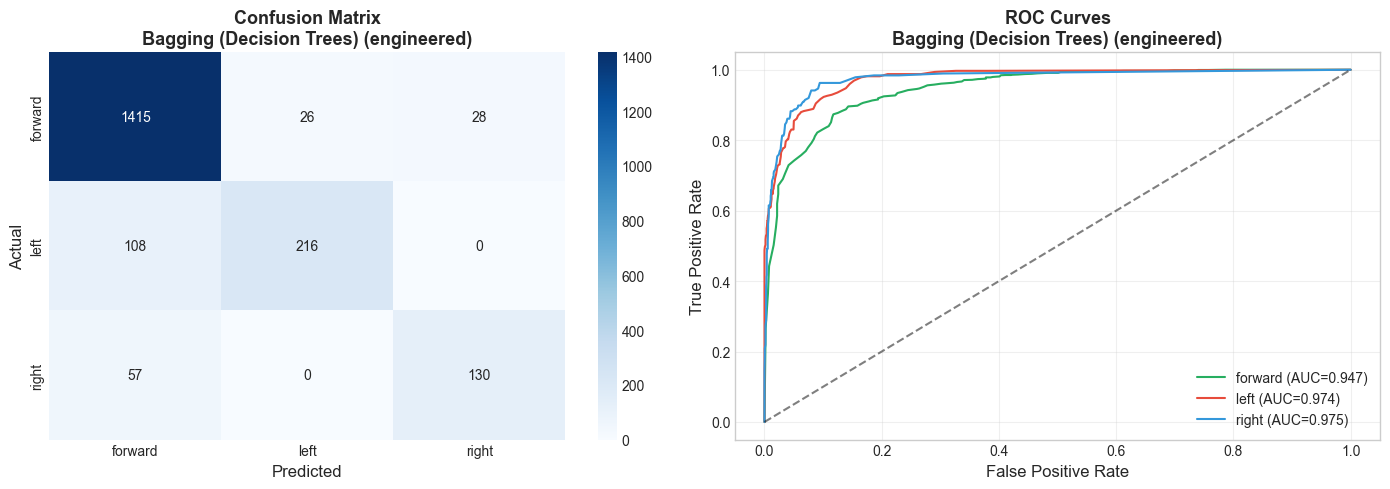

In [4]:
# Train Bagging on ENGINEERED features
print("Training Bagging Classifier on ENGINEERED features...")

bagging_eng = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=None, class_weight='balanced', random_state=RANDOM_STATE),
    n_estimators=100,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    oob_score=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

bagging_eng.fit(eng_processed['X_train'], eng_processed['y_train'])

print(f"OOB Score: {bagging_eng.oob_score_:.4f}")

results_bag_eng = evaluate_model(
    bagging_eng,
    eng_processed['X_test'],
    eng_processed['y_test'],
    model_name='Bagging (Decision Trees)',
    feature_type='engineered',
    label_encoder=eng_processed['label_encoder']
)


## 3. Results Summary


In [5]:
# Summary
all_results = [results_bag_raw, results_bag_eng]

summary_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Features': r['feature_type'],
        'Accuracy': r['accuracy'],
        'Balanced Acc': r['balanced_accuracy'],
        'F1 (Macro)': r['f1_macro'],
        'ROC-AUC': r['roc_auc']
    }
    for r in all_results
])

print("\n" + "="*80)
print("BAGGING RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))



BAGGING RESULTS SUMMARY
                   Model   Features  Accuracy  Balanced Acc  F1 (Macro)  ROC-AUC
Bagging (Decision Trees)        raw  0.917172      0.851261    0.870304 0.975784
Bagging (Decision Trees) engineered  0.889394      0.775031    0.815016 0.964913


In [6]:
# Save results
save_results(all_results, 'bagging')
print("Results saved successfully!")


Results saved to ../../data/model_results/bagging_results.json
Results saved successfully!


## 4. Key Observations

### Bagging vs Single Tree
- Bagging reduces variance by averaging multiple trees
- More stable predictions than a single decision tree
- OOB score provides built-in cross-validation estimate

### Comparison with Random Forest
- Bagging uses all features at each split
- Random Forest randomly subsets features (decorrelates trees)
- Random Forest typically performs better due to this decorrelation

### Trade-offs
- Loses interpretability of single trees
- Computationally more expensive
- But significant improvement in prediction accuracy
